In [1]:
import cudf
import pandas as pd
import numpy as np
import time

/nvme/0/pgali/envs/cudfdev/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
np.random.seed(0)

In [3]:
pdf = pd.DataFrame({
    "numbers": np.random.randint(-1000, 1000, 10_000_000, dtype='int64'),
    "business": np.random.choice(["McD", "Buckees", "Walmart", "Costco"], size=10_000_000)
})

In [4]:
pdf

,numbers,business
0,-316,Buckees
1,-441,Costco
2,653,McD
3,216,Buckees
4,-165,Walmart
...,...,...
9999995,908,Costco
9999996,338,McD
9999997,885,Buckees
9999998,-391,McD


In [5]:
gdf = cudf.from_pandas(pdf)

In [6]:
gdf

,numbers,business
0,-316,Buckees
1,-441,Costco
2,653,McD
3,216,Buckees
4,-165,Walmart
...,...,...
9999995,908,Costco
9999996,338,McD
9999997,885,Buckees
9999998,-391,McD


In [7]:
def time_it(callable):
    start = time.time()
    callable()
    end = time.time()
    return end - start

In [8]:
start = time.time()
pdf.to_parquet("pandas.parquet")
end = time.time()

In [9]:
pandas_to_parquet = time_it(lambda : pdf.to_parquet("pandas.parquet"))

In [10]:
cudf_to_parquet = time_it(lambda : gdf.to_parquet("cudf.parquet"))

In [11]:
pandas_read_parquet = time_it(lambda : pd.read_parquet("pandas.parquet"))

In [12]:
cudf_read_parquet = time_it(lambda : cudf.read_parquet("cudf.parquet"))

In [13]:
pandas_to_csv = time_it(lambda : pdf.to_csv("pandas.csv"))

In [14]:
cudf_to_csv = time_it(lambda : gdf.to_csv("cudf.csv"))

In [15]:
pandas_read_csv = time_it(lambda : pd.read_csv("pandas.csv"))

In [16]:
cudf_read_csv = time_it(lambda : cudf.read_csv("cudf.csv"))

In [17]:
pandas_groupby = time_it(lambda : pdf.groupby("business").agg(["min", "max", "mean"]))

In [18]:
cudf_groupby = time_it(lambda : gdf.groupby("business").agg(["min", "max", "mean"]))

In [22]:
# TODO : Remove this memory limitation(from pandas side) slicing 
pdf = pd.DataFrame({
    "numbers": np.random.randint(-1000, 1000, 1_000_00, dtype='int64'),
    "business": np.random.choice(["McD", "Buckees", "Walmart", "Costco"], size=1_000_00)
})
gdf = cudf.from_pandas(pdf)

In [23]:
pandas_merge = time_it(lambda : pdf.merge(pdf))

In [24]:
cudf_merge = time_it(lambda : gdf.merge(gdf))

In [25]:
import matplotlib.pyplot as plt

In [26]:
perf_df = pd.DataFrame(
    {
        "cudf speed up v/s pandas": [pandas_to_parquet/cudf_to_parquet, pandas_read_parquet/cudf_read_parquet, pandas_to_csv/cudf_to_csv, pandas_read_csv/cudf_read_csv, pandas_groupby/cudf_groupby, pandas_merge/cudf_merge],
}, index=["to_parquet", "read_parquet", "to_csv", "read_csv", "groupby", "merge"])

In [27]:
perf_df

,cudf speed up v/s pandas
to_parquet,10.477332
read_parquet,18.189531
to_csv,24.120781
read_csv,13.679503
groupby,40.277891
merge,22.753797


[Text(0, 0, '10.4773'),
 Text(0, 0, '18.1895'),
 Text(0, 0, '24.1208'),
 Text(0, 0, '13.6795'),
 Text(0, 0, '40.2779'),
 Text(0, 0, '22.7538')]

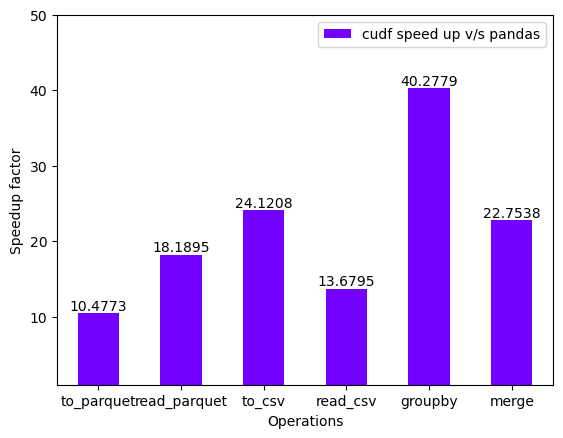

In [28]:
ax = perf_df.plot.bar(color='#7400ff', ylim=(1,50), rot=0)
ax.set_xlabel("Operations")
ax.set_ylabel("Speedup factor")
ax.bar_label(ax.containers[0])

In [29]:
pd_series = pd.Series(np.random.choice(["123", "56.234", "Walmart", "Costco", "rapids ai"], size=10_000_0000))

In [30]:
gd_series = cudf.from_pandas(pd_series)

In [31]:
pandas_upper = time_it(lambda : pd_series.str.upper())

In [32]:
cudf_upper = time_it(lambda : gd_series.str.upper())

In [33]:
pandas_contains = time_it(lambda : pd_series.str.contains(r"[0-9][a-z]"))

In [34]:
cudf_contains = time_it(lambda : gd_series.str.contains(r"[0-9][a-z]"))

In [35]:
pandas_isalpha = time_it(lambda : pd_series.str.isalpha())

In [36]:
cudf_isalpha = time_it(lambda : gd_series.str.isalpha())

In [37]:
perf_df = pd.DataFrame(
    {
        "cudf speed up v/s pandas": [pandas_upper/cudf_upper, pandas_contains/cudf_contains, pandas_isalpha/cudf_isalpha,],
}, index=["upper", "contains", "is_alpha",])

[Text(0, 0, '161.008'), Text(0, 0, '96.5185'), Text(0, 0, '432.102')]

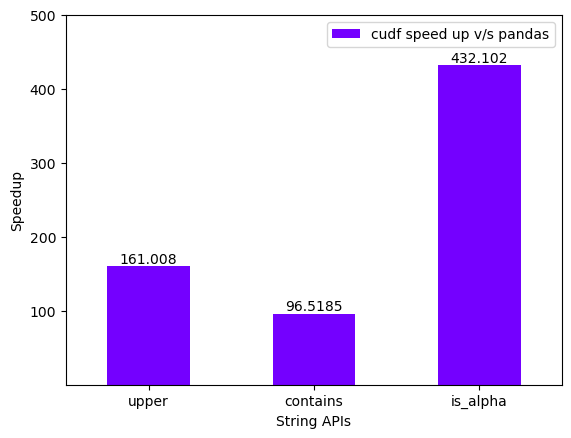

In [40]:
ax = perf_df.plot.bar(color='#7400ff', ylim=(1,500), rot=0)
ax.set_xlabel("String APIs")
ax.set_ylabel("Speedup")
ax.bar_label(ax.containers[0])

## UDF

In [41]:

size = 10000000
pdf = pd.DataFrame({
    'age': np.random.randint(0,100,size),
})

In [42]:
def f(row):
    if row['age'] < 18:
        return 0
    elif 18 <= row['age'] < 20:
        return 1
    elif 20 <= row['age'] < 30:
        return 2
    elif 30 <= row['age'] < 40:
        return 3
    elif 40 <= row['age'] < 50:
        return 4
    elif 50 <= row['age'] < 60:
        return 5
    elif 60 <= row['age'] < 70:
        return 6
    else:
        return 7

In [58]:
gdf = cudf.from_pandas(pdf)

In [44]:
pandas_int_udf = time_it(lambda : pdf.apply(f, axis=1))

In [45]:
cudf_int_udf = time_it(lambda : gdf.apply(f, axis=1))

In [46]:
def str_func(row):
    if row['strings'].isupper():
        return 0
    else:
        return 1

In [48]:
pd_series = pd.Series(np.random.choice(["ABC", "abc", "hello world", "AI"], size=10_000_000), name='strings').to_frame()

In [49]:
gd_series = cudf.from_pandas(pd_series)

In [50]:
pandas_str_udf = time_it(lambda : pd_series.apply(str_func, axis=1))

In [59]:
cudf_str_udf = time_it(lambda : gd_series.apply(str_func, axis=1))

In [52]:
size = 100000000
pdf = pd.DataFrame()
pdf['key'] = np.random.randint(0,2,size)
pdf['val'] = np.random.randint(0,7,size)


def mult(df):
  df['out'] = df['key'] * df['val'] - 10
  return df


gdf = cudf.from_pandas(pdf)

In [53]:
pandas_udf_groupby = time_it(lambda : pdf.groupby(['key']).apply(mult))

/tmp/ipykernel_43492/3640856620.py:1: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  pandas_udf_groupby = time_it(lambda : pdf.groupby(['key']).apply(mult))


In [54]:
cudf_udf_groupby = time_it(lambda : gdf.groupby(['key']).apply(mult))

In [55]:
perf_df = pd.DataFrame(
    {
    "cudf speed up v/s pandas": [pandas_int_udf/cudf_int_udf, pandas_str_udf/cudf_str_udf, pandas_udf_groupby/cudf_udf_groupby],
}, index=["int_udf", "str_udf", "groupby_udf"])

[Text(0, 0, '58.2354'), Text(0, 0, '29.718'), Text(0, 0, '74.0731')]

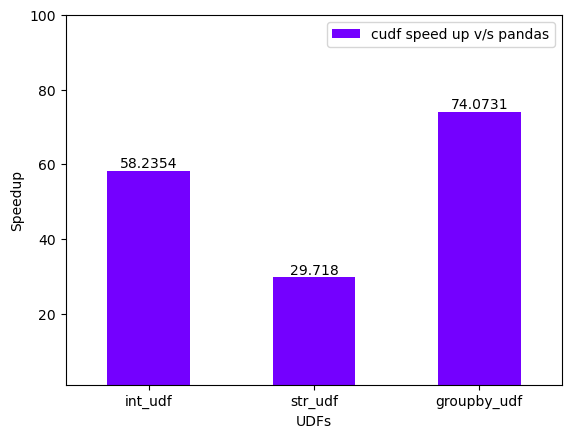

In [57]:
ax = perf_df.plot.bar(color='#7400ff', ylim=(1,100), rot=0)
ax.set_xlabel("UDFs")
ax.set_ylabel("Speedup")
ax.bar_label(ax.containers[0])

## Second run for UDF

TODO: Explain the code is jit compiled.

/tmp/ipykernel_43492/3808839728.py:46: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  pandas_udf_groupby = time_it(lambda : pdf.groupby(['key']).apply(mult))


[Text(0, 0, '16710.2'), Text(0, 0, '3441.41'), Text(0, 0, '74.7759')]

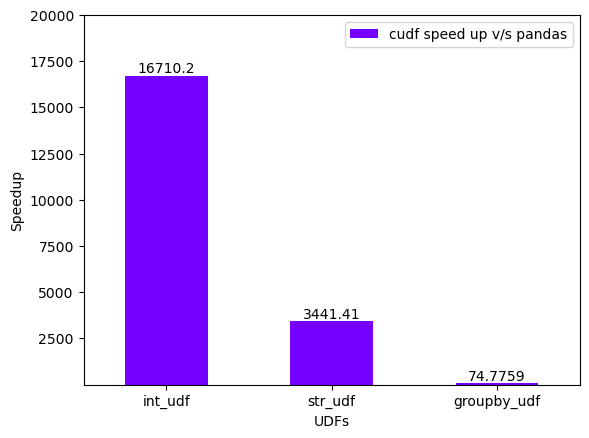

In [61]:

size = 10000000
pdf = pd.DataFrame({
    'age': np.random.randint(0,100,size),
})
def f(row):
    if row['age'] < 18:
        return 0
    elif 18 <= row['age'] < 20:
        return 1
    elif 20 <= row['age'] < 30:
        return 2
    elif 30 <= row['age'] < 40:
        return 3
    elif 40 <= row['age'] < 50:
        return 4
    elif 50 <= row['age'] < 60:
        return 5
    elif 60 <= row['age'] < 70:
        return 6
    else:
        return 7
gdf = cudf.from_pandas(pdf)
pandas_int_udf = time_it(lambda : pdf.apply(f, axis=1))
cudf_int_udf = time_it(lambda : gdf.apply(f, axis=1))
def str_func(row):
    if row['strings'].isupper():
        return 0
    else:
        return 1
pd_series = pd.Series(np.random.choice(["ABC", "abc", "hello world", "AI"], size=10_000_000), name='strings').to_frame()
gd_series = cudf.from_pandas(pd_series)
pandas_str_udf = time_it(lambda : pd_series.apply(str_func, axis=1))
cudf_str_udf = time_it(lambda : gd_series.apply(str_func, axis=1))
size = 100000000
pdf = pd.DataFrame()
pdf['key'] = np.random.randint(0,2,size)
pdf['val'] = np.random.randint(0,7,size)


def mult(df):
  df['out'] = df['key'] * df['val'] - 10
  return df


gdf = cudf.from_pandas(pdf)
pandas_udf_groupby = time_it(lambda : pdf.groupby(['key']).apply(mult))
cudf_udf_groupby = time_it(lambda : gdf.groupby(['key']).apply(mult))
perf_df = pd.DataFrame(
    {
    "cudf speed up v/s pandas": [pandas_int_udf/cudf_int_udf, pandas_str_udf/cudf_str_udf, pandas_udf_groupby/cudf_udf_groupby],
}, index=["int_udf", "str_udf", "groupby_udf"])
ax = perf_df.plot.bar(color='#7400ff', ylim=(1,20000), rot=0)
ax.set_xlabel("UDFs")
ax.set_ylabel("Speedup")
ax.bar_label(ax.containers[0])